In [9]:
from library.GCN import GraphData, ChemGCN, Graph, Standardizer, collate_graph_dataset
from sklearn.metrics import mean_absolute_error
from torch.utils.data import  Subset, Dataset
import matplotlib.pyplot as plt
from library.cVAE_helper import (
    smiles_to_idxs,
    create_model,
    get_vocab,
)

from pathlib import Path
import numpy as np
import torch
import json

In [10]:
DATA_PATH = Path.cwd().parents[0] / "data"
DEVICE = 'cpu'

In [11]:
# Fixed params
FIXED_PARAMS = {
    'max_atoms': 30,
    'node_vec_len': 16,
    'use_GPU': False,  # Set to True if CUDA available
    'vocab_size': 24,
    'batch_size': 1000,
    'p_dropout': 0.1,
    'n_epochs': 15
}

path = DATA_PATH / "cVAE" / "results" / "fold_2_stratified_results.json"
with open(path, 'r') as file:
    fold_data = json.load(file)

INIT_PARAMS = {
            "learning_rate": fold_data["learning_rate"],
            "latent_dim": fold_data["latent_dim"],
            "n_hidden": fold_data["n_hidden"],
            "gru_dim": fold_data["gru_dim"],
            "n_conv_layers": fold_data["n_conv_layers"],
            "n_hidden_layers": fold_data["n_hidden_layers"],
            "n_gru_layers": fold_data["n_gru_layers"],
            "n_fc_layers": fold_data["n_fc_layers"],
            "embedding_dim": fold_data["embedding_dim"],
            "teacher_forcing_ratio": fold_data["teacher_forcing_ratio"],
            "beta": fold_data["beta"]
}

In [12]:
def generate_random_molecule(
        model,
        n_samples,
        latent_dim,
        y_value,
        seq_length,
        device=DEVICE
): 
    model.eval()

    # Take random sample latent vector
    z = torch.randn(1, latent_dim, device=device)
    z_repeated = z.repeat(n_samples, 1)

    # Property conditioning
    y = torch.full((n_samples, 1), y_value, device=device)

    with torch.no_grad():
        token_seqs = model.sample(z_repeated, y, seq_length=seq_length)

    return token_seqs

In [13]:
from rdkit import Chem
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.error')

def filter_valid_smiles(smiles_list):
    valid_smiles = []
    valid_mols = []
    valid_idxs = []

    for i, s in enumerate(smiles_list):
        if not s:
            continue
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            valid_smiles.append(s)
            valid_mols.append(mol)
            valid_idxs.append(i)

    return valid_smiles, valid_mols, valid_idxs

In [14]:
# Load in the dataset
data_path = DATA_PATH / "RDKit" / "rdkit_only_valid_smiles_qm9.pkl"
dataset = GraphData(dataset_path=data_path, max_atoms=FIXED_PARAMS['max_atoms'], node_vec_len=FIXED_PARAMS['node_vec_len'])

gaps: list[float] = dataset.outputs
smiles_list: list[str] = dataset.smiles

vocab_list, _ = get_vocab(smiles_list)

# Create token2index mapping and its inverse
global token2idx
token2idx = {tok: idx for idx, tok in enumerate(vocab_list)}
idx2token = {idx: tok for tok, idx in token2idx.items()}

dataset_indices = np.arange(0, len(dataset), 1)

In [15]:
gaps = [float(dataset[i][1]) for i in range(len(dataset))]
standardizer = Standardizer(torch.Tensor(gaps))

In [16]:
model, *_ = create_model(INIT_PARAMS, FIXED_PARAMS, DEVICE)

In [17]:
PATH = DATA_PATH / 'cVAE' / 'cvae_model' / 'fold_2_stratified_model.pt'

In [18]:
# Load the best performing model from the hyperparameter tuning
model.load_state_dict(torch.load(PATH, weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

In [19]:
# Initialize the stand-alone GCN model and load the trained weights (because all models have the same weight, it doesnt matter which one we choose)

max_atoms = 30 # fixed value
node_vec_len = 16 # fixed value
batch_size = 256
hidden_nodes = 128
n_conv_layers = 4
n_hidden_layers = 2
learning_rate = 0.003
n_epochs = 50
use_GPU = False

GCN_model = ChemGCN(node_vec_len=node_vec_len,
                node_fea_len=hidden_nodes,
                hidden_fea_len=hidden_nodes,
                n_conv=n_conv_layers,
                n_hidden=n_hidden_layers,
                n_outputs=1,
                p_dropout=0.1)

state_dict = torch.load(
    DATA_PATH / 'GCN' / 'GCN_outer_fold_weights' / 'GCN_weight_outer_fold_0.pth',
    map_location='cpu'
)

GCN_model.load_state_dict(state_dict)

<All keys matched successfully>

In [20]:
convert = lambda x: idx2token[int(x)]

In [21]:
# determine the average sequence length in the dataset and its 95 CI
lengths = [len(smiles) for smiles in smiles_list]
print(mu := np.mean(lengths))
print(sigma := np.std(lengths))
print(mu - 2* sigma, mu + 2 * sigma)

64.4219762502713
15.541395384283067
33.339185481705165 95.50476701883744


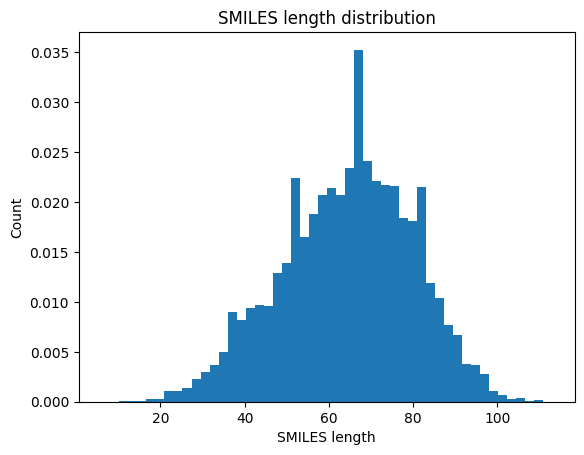

In [22]:
plt.hist(lengths, bins=50, density=True)
plt.xlabel("SMILES length")
plt.ylabel("Count")
plt.title("SMILES length distribution")
plt.show()

In [23]:
class SMILESDataset(Dataset):
    """Custom placeholder class used to store generated molecules"""
    def __init__(self, smiles_list, node_vec_len, max_atoms):
        self.smiles = smiles_list
        self.node_vec_len = node_vec_len
        self.max_atoms = max_atoms

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = self.smiles[idx]
        mol = Graph(smile, self.node_vec_len, self.max_atoms)
        node_mat = torch.Tensor(mol.node_mat)
        adj_mat = torch.Tensor(mol.adj_mat)
        # dummy output placeholder, we don't know true gaps
        output = torch.Tensor([0.0])
        return (node_mat, adj_mat), output, smile


In [24]:
def get_MAE(smiles, target_gap, standardizer=standardizer):
    """Use the GCN model to determine a HOMO-LUMO gap for a generated molecule and return MAE of this gap compared to the target gap"""
    gap_tensor = torch.tensor(target_gap).repeat(len(smiles), 1)
    
    smiles_dataset = SMILESDataset(smiles, node_vec_len, max_atoms)
    (node_mats_tensor, adj_mats_tensor), outputs_tensor, smiles_list = collate_graph_dataset(smiles_dataset)

    first_dim = int(torch.numel(node_mats_tensor) / (max_atoms * node_vec_len))
    node_mats_tensor = node_mats_tensor.reshape(first_dim, max_atoms, node_vec_len)
    adj_mats_tensor = adj_mats_tensor.reshape(first_dim, max_atoms, max_atoms)

    GCN_model.eval()
    with torch.no_grad():
        nn_predictions = GCN_model(node_mats_tensor, adj_mats_tensor)

    predictions = standardizer.restore(nn_predictions.detach().cpu())

    mae = mean_absolute_error(gap_tensor, predictions)
    return mae

The 10 samples **randomly** taken from the latent space (normal distribution). For each sample, 1000 smiles are generated.

In [25]:
n_latents = 10
n_trials = 1000
latent_dim = model.latent_dim  # your cVAE latent dimension
seq_length = 64  # average sequence length of the dataset

rng = np.random.default_rng(seed=15)
target_gaps = rng.uniform(4, 10, n_latents)  # example target gaps

results_random = []
for i in range(n_latents):
    z = torch.randn(1, latent_dim, device=DEVICE)  # random latent vector
    gap = torch.tensor([[target_gaps[i]]], device=DEVICE, dtype=torch.float32)  # fixed gap
    gen_smiles_list = []

    for _ in range(n_trials):
        with torch.no_grad():
            token_seq = model.sample(z, gap, seq_length=seq_length).squeeze(0)
        gen_smiles = "".join(map(convert, token_seq))
        gen_smiles_list.append(gen_smiles)

    # Filter valid SMILES
    valid_smiles, valid_mols, valid_idxs = filter_valid_smiles(gen_smiles_list)
    validity = len(valid_smiles) / n_trials

    mae = get_MAE(valid_smiles, target_gaps[i])

    results_random.append({
        "source": "random",
        "base_id": i,
        "target_gap": float(target_gaps[i]),
        "validity": validity,
        "mae": mae,
        "valid_mols": valid_mols
    })

    print(f"Random latent {i}: Validity = {validity:.3f}, MAE = {mae:.3f}")

Random latent 0: Validity = 0.066, MAE = 0.605
Random latent 1: Validity = 0.054, MAE = 0.543
Random latent 2: Validity = 0.048, MAE = 0.886
Random latent 3: Validity = 0.011, MAE = 1.135
Random latent 4: Validity = 0.066, MAE = 0.726
Random latent 5: Validity = 0.018, MAE = 0.992
Random latent 6: Validity = 0.044, MAE = 0.467
Random latent 7: Validity = 0.036, MAE = 0.817
Random latent 8: Validity = 0.048, MAE = 0.904
Random latent 9: Validity = 0.061, MAE = 0.850


In [26]:
n_molecules = 10
n_trials = 1000
latent_noise_scale = 0.05

results_dataset = []

# random_indices = rng.choice(len(dataset), n_molecules, replace=False)
random_indices = [108853, 71614, 18152, 27851, 100812, 67261, 121478, 12789, 114626, 2364]

for idx in random_indices:
    node_mat = dataset[idx][0][0].unsqueeze(0)
    adj_mat = dataset[idx][0][1].unsqueeze(0)
    smiles = smiles_to_idxs([dataset[idx][2]], token2idx, DEVICE)

    # Gap condition: keep fixed for all trials
    gap = dataset[idx][1]
    gap_tensor = torch.tensor([[gap]], device=DEVICE)

    gen_smiles_list = []

    # Encode molecule
    model(node_mat, adj_mat, smiles, gap_tensor)
    mu = model.z_mean
    logvar = model.z_logvar
    sigma = torch.exp(0.5 * logvar)

    for _ in range(n_trials):
        with torch.no_grad():
            # Sample latent vector
            z = mu + sigma * torch.randn_like(sigma)
            z = z + latent_noise_scale * torch.randn_like(z)

            # Decode
            token_seq = model.sample(z, gap_tensor, seq_length=smiles.size(-1)).squeeze(0)
            gen_smiles_list.append("".join(map(convert, token_seq)))

    # Filter valid SMILES
    valid_smiles, valid_mols, valid_idxs = filter_valid_smiles(gen_smiles_list)
    validity = len(valid_smiles) / n_trials

    mae = get_MAE(valid_smiles, gap)

    results_dataset.append({
        "source": "dataset",
        "base_id": idx,
        "target_gap": gap,
        "validity": validity,
        "mae": mae,
        "valid_mols": valid_mols
    })

    print(f"Dataset molecule {idx}: Validity = {validity:.3f}, MAE = {mae:.3f}")


/tmp/ipykernel_8314/4229564846.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gap_tensor = torch.tensor(target_gap).repeat(len(smiles), 1)


Dataset molecule 108853: Validity = 0.042, MAE = 0.918


/tmp/ipykernel_8314/4229564846.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gap_tensor = torch.tensor(target_gap).repeat(len(smiles), 1)


Dataset molecule 71614: Validity = 0.018, MAE = 0.926


/tmp/ipykernel_8314/4229564846.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gap_tensor = torch.tensor(target_gap).repeat(len(smiles), 1)


Dataset molecule 18152: Validity = 0.045, MAE = 0.620


/tmp/ipykernel_8314/4229564846.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gap_tensor = torch.tensor(target_gap).repeat(len(smiles), 1)


Dataset molecule 27851: Validity = 0.045, MAE = 0.748


/tmp/ipykernel_8314/4229564846.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gap_tensor = torch.tensor(target_gap).repeat(len(smiles), 1)


Dataset molecule 100812: Validity = 0.049, MAE = 0.796


/tmp/ipykernel_8314/4229564846.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gap_tensor = torch.tensor(target_gap).repeat(len(smiles), 1)


Dataset molecule 67261: Validity = 0.034, MAE = 0.609


/tmp/ipykernel_8314/4229564846.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gap_tensor = torch.tensor(target_gap).repeat(len(smiles), 1)


Dataset molecule 121478: Validity = 0.055, MAE = 0.806


/tmp/ipykernel_8314/4229564846.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gap_tensor = torch.tensor(target_gap).repeat(len(smiles), 1)


Dataset molecule 12789: Validity = 0.061, MAE = 0.707


/tmp/ipykernel_8314/4229564846.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gap_tensor = torch.tensor(target_gap).repeat(len(smiles), 1)


Dataset molecule 114626: Validity = 0.026, MAE = 0.890
Dataset molecule 2364: Validity = 0.042, MAE = 0.369


/tmp/ipykernel_8314/4229564846.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gap_tensor = torch.tensor(target_gap).repeat(len(smiles), 1)


In [27]:
n = 1000          # number of binary observations per average
z = 1.96          # 95% confidence level

# standard error for each proportion
se = lambda p: np.sqrt(p * (1 - p) / n)

0.0452
0.0417


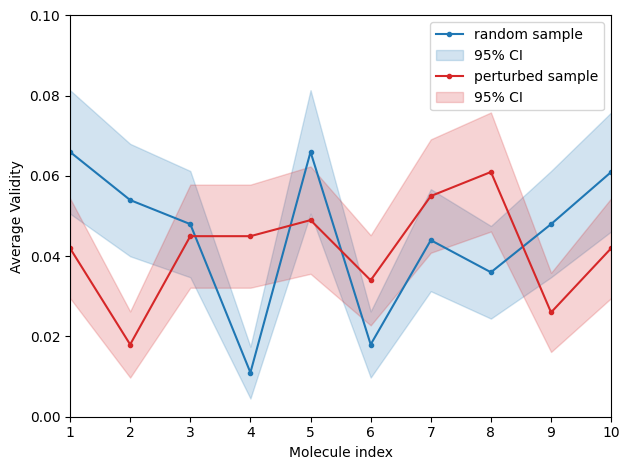

In [ ]:
random_validities = np.array([result['validity'] for result in results_random])
dataset_validities = np.array([result['validity'] for result in results_dataset])

print(random_validities.mean())
print(dataset_validities.mean())

random_std = se(random_validities)
dataset_std = se(dataset_validities)

# confidence intervals
random_ci_lower = random_validities - z * random_std
random_ci_upper = random_validities + z * random_std

dataset_ci_lower = dataset_validities - z * dataset_std
dataset_ci_upper = dataset_validities + z * dataset_std

data_range = np.arange(1, 11)

plt.plot(data_range, random_validities, color='tab:blue', label=f'random sample', marker='.')

# Fill between the confidence interval
plt.fill_between(data_range, random_ci_lower, random_ci_upper, color='tab:blue', alpha=0.2, label='95% CI')

plt.plot(data_range, dataset_validities, color='tab:red', linestyle='-', label=f'perturbed sample', marker='.')

# Fill between the confidence interval
plt.fill_between(data_range, dataset_ci_lower, dataset_ci_upper, color='tab:red', alpha=0.2, label='95% CI')

# plt.plot(data_range, np.ones_like(data_range) * np.mean(random_validities), color='tab:blue', linestyle='--', label='mean of random samples')
# plt.plot(data_range, np.ones_like(data_range) * np.mean(dataset_validities), color='tab:red', linestyle='--', label='mean of perturbed samples')

plt.xlim(1, 10)
plt.ylim(0, 0.1)

plt.ylabel("Average Validity")
plt.xlabel("Molecule index")

plt.legend()
plt.tight_layout()
# plt.savefig("avg_validity.png", dpi=300)
plt.show()

0.7925101066965582
0.7387817889451981


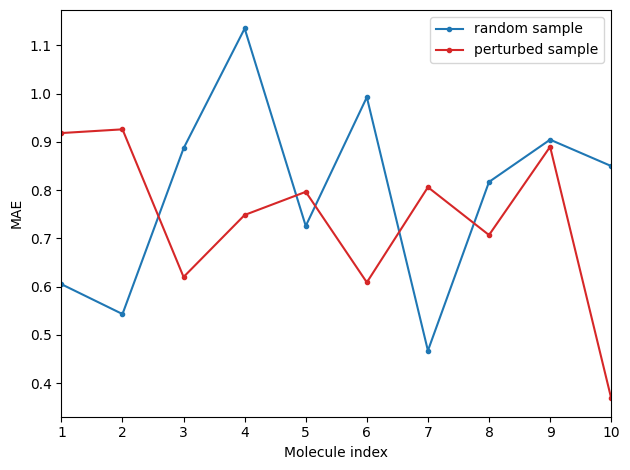

In [ ]:
# random_maes = [1.453, 1.242, 3.543, 3.889, 1.999, 3.845, 1.349, 3.335, 2.816, 1.032]
# perturbed_maes = [0.742, 0.975, 0.609, 0.736, 0.943, 0.434, 0.695, 0.712, 0.946, 0.424]

random_maes = np.array([result['mae'] for result in results_random])
perturbed_maes = np.array([result['mae'] for result in results_dataset])

print(random_maes.mean())
print(perturbed_maes.mean())

plt.plot(data_range, random_maes, color='tab:blue', label=f'random sample', marker='.')
plt.plot(data_range, perturbed_maes, color='tab:red', label=f'perturbed sample', marker='.')

plt.ylabel("MAE")
plt.xlabel("Molecule index")

plt.xlim(1, 10)

plt.legend()
plt.tight_layout()
# plt.savefig("cvae_maes.png", dpi=300)
plt.show()

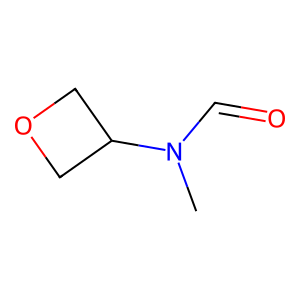

In [30]:
molidx = 7
molecule_data = results_dataset[molidx]
original_smiles = dataset[molecule_data['base_id']][-1]
mol = Chem.MolFromSmiles(original_smiles)
img = Chem.Draw.MolToImage(mol, size=(300, 300))
# img.save(f"../img/mol{molidx+1}_OG.png")
img

In [31]:
mol.GetNumAtoms()
len(original_smiles)

54

In [32]:
mol1 = molecule_data['valid_mols'][0]
mol2 = molecule_data['valid_mols'][1]
mol3 = molecule_data['valid_mols'][2]
mol4 = molecule_data['valid_mols'][3]
mol5 = molecule_data['valid_mols'][4]
mol6 = molecule_data['valid_mols'][5]
mol7 = molecule_data['valid_mols'][6]
mol8 = molecule_data['valid_mols'][7]

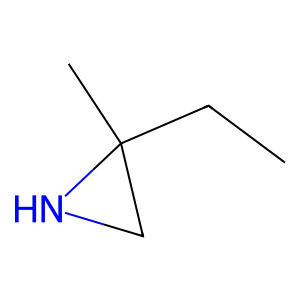

In [33]:
img1 = Chem.Draw.MolToImage(mol1, size=(300, 300))
# img1.save(f"../img/mol{molidx+1}_1.png")
img1

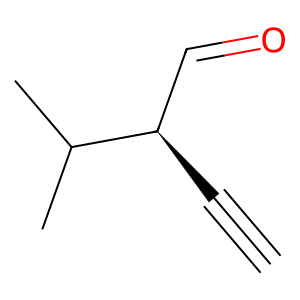

In [34]:
img2 = Chem.Draw.MolToImage(mol2, size=(300, 300))
# img2.save(f"../img/mol{molidx+1}_2.png")
img2

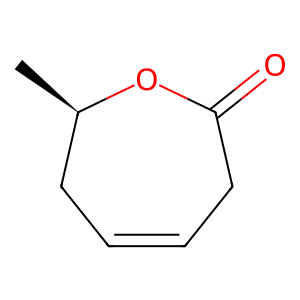

In [35]:
img3 = Chem.Draw.MolToImage(mol3, size=(300, 300))
# img3.save(f"../img/mol{molidx+1}_3.png")
img3

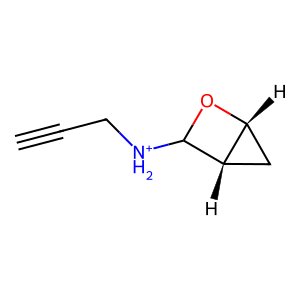

In [36]:
img4 = Chem.Draw.MolToImage(mol4, size=(300, 300))
# img4.save(f"../img/mol{molidx+1}_4.png")
img4

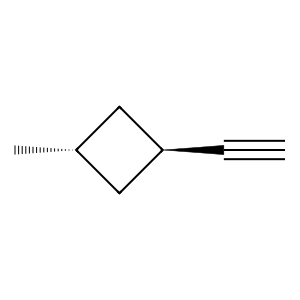

In [37]:
Chem.Draw.MolToImage(mol5, size=(300, 300))

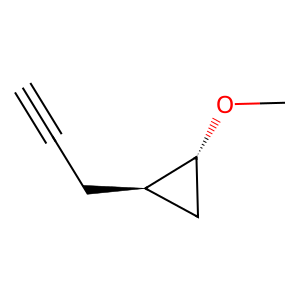

In [38]:
Chem.Draw.MolToImage(mol6, size=(300, 300))

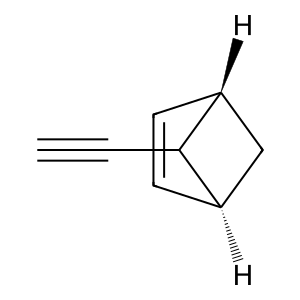

In [39]:
Chem.Draw.MolToImage(mol7, size=(300, 300))

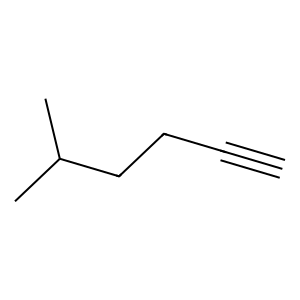

In [40]:
Chem.Draw.MolToImage(mol8, size=(300, 300))